In [1]:
# For Google Colab / local machine
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
    import sys
    sys.path.append(colab_path)
else:
    print('Not running on CoLab')
    colab_path = ""

Not running on CoLab


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
from copy import deepcopy
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as signal
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

# Create list for indices with partners that did not
# take part in the experiment together
# with an equal gender distribution, e.g.:
# 0 1 2 3 4 5 6 7
# ->
# 0 3 4 7
sync_idx = sorted(
    [*participants[::4],
     *participants[3::4]])

In [3]:
# Cosine interpolation
def cosine(x, x1, x2):
    """Returns cosine value (y) for given time step (x) in one period (T) based on the interval between x1 and x2.

    Args:
        x (float): time step
        x1 (float): period start (y=1)
        x2 (float): period end (y=1)

    Returns:
        val (float): cosine value
    """
    from math import cos, pi
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def rpeaks_cosine_interpolation(rpeaks_idx, length):
    """Returns a cosine interpolation with varying frequency for successive events (rpeaks_idx) of a binary time series.

    Args:
        rpeaks_idx (array): index of r-peaks in the time series
        length (int): length of the time series

    Returns:
        rpeaks_cip : cosine interpolation of rpeaks
    """
    num_rpeaks = len(rpeaks_idx)
    
    # Interpolation
    rpeaks_cip = [np.nan]*(rpeaks_idx[0])

    for i in range(num_rpeaks):
        if i == num_rpeaks-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2)
        # span interval with corresponding number of time steps
        x = np.linspace(x1, x2, T)
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(length-rpeaks_idx[-1])
    # keep in mind: there are nans at the start and end

    return rpeaks_cip

In [4]:
# Make some noise
# discrete normal distribution

def make_noise(rpeaks_idx, noise_spread=10):
    """Generates n = rpeaks_idx discrete normal distribution with a sum of 0 and a standard deviation of noise_spread.\n
        As there is no deterministic way to determine these values a while-loop is incoorperated. 
        The higher noise_spread, the more time it takes.\n
        Returns a nested list with n numbers of noise and percentage of noise based on the mean IBI value.

    Args:
        rpeaks_idx (array): n & mean IBI
        noise_spread (int, optional): standard deviation of noise. Defaults to 10.

    Returns:
        [noise, noise_percentage] : nested list
    """
    num_rpeaks = len(rpeaks_idx)
    noise_size = num_rpeaks-2
    # num_rpeaks-2, 
    # because the first r-peak index does not represent an IBI
    # and the noise should end at the last original IBI

    noise = np.round(
        np.random.normal(
            scale=noise_spread, 
            size=noise_size))
    # Search for sum = 0
    while \
        sum(noise) != 0 or \
        np.round(np.std(noise), 1) != noise_spread:
        noise = np.round(
            np.random.normal(
                scale=noise_spread, 
                size=noise_size))
    # Convert to ints
    noise = [round(x) for x in noise]
    noise.insert(0, 0)
    noise.append(0)
    
    # Calculate average noise (%)
    # Get IBI
    ibi = [
        rpeaks_idx[s]-rpeaks_idx[s-1]
        for s in range(num_rpeaks)
        if s > 0
    ]
    
    ibi_mean = np.mean(np.array(ibi))
    noise_percentage = np.mean(abs(np.array(noise)))/ibi_mean*100
    noise_percentage = np.round(noise_percentage, 2)
    
    return [noise, noise_percentage]

# Preprocess data

In [5]:
sampling_rate = 2000
length = 5*60*sampling_rate

ecg_raw = {}
ecg = {}
rpeaks = {}
rpeaks_idx = {}
noise = []
con = "gaze"

In [6]:
# Prepeare original sample date based on con (SIT or GAZE)

# Load data: raw ecgs for 300 s at 2000 Hz
ecg_raw[con] = np.load(f"{colab_path}data/ecg_raw/ecg_raw_{con}.npy")

# Clean and normalize data
ecg[con] = [
    nk.ecg_clean(
        ecg_raw[con][i], 
        sampling_rate=sampling_rate, 
        method="neurokit")
    for i in participants
]
# Get R-peaks as a binary time series
rpeaks[con] = [
    nk.ecg_peaks(
        ecg[con][i], 
        sampling_rate=sampling_rate
        )[0]["ECG_R_Peaks"]
    for i in participants
]
rpeaks_idx[con] = [
    [
        s for s, 
        x in enumerate(rpeaks[con][i]) 
        if x == 1
    ]
    for i in participants
]


In [7]:
# Create SYNC with lag and different levels of noise based on sample data

noise_spread = [0,5,10]
noise = {}
noise_added = {}


for x in noise_spread:
    noise[x] = [
        # returns 2 vaules in a nested list: noise vaules @ [0] & noise percentage @ [1]
        make_noise(rpeaks_idx[con][i],noise_spread=x)
        for i in participants
    ]

    rpeaks_idx["sync_temp"] = [
        np.array(rpeaks_idx["gaze"][i])+(noise[x][i][0])
        for i in participants
    ]

    rpeaks_idx[f"sync_{x}"] = [None]*(len(participants))
    rpeaks_idx[f"sync_{x}"][::2] = [
        rpeaks_idx["gaze"][idx]
        for idx in sync_idx
    ]
    rpeaks_idx[f"sync_{x}"][1::2] = [
        rpeaks_idx["sync_temp"][idx]
        for idx in sync_idx
    ]

    del rpeaks_idx["sync_temp"]

    # Add lag
    lag = 1*sampling_rate # 1 sec
    rpeaks_idx[f"sync_{x}"][1::2] = [
        rpeaks_idx[f"sync_{x}"][i]+np.array(lag)
        for i in participants
        if i % 2 == 1
    ]
    
    # Show noise
    noise_added[x] = [
        noise[x][idx][1]
        for idx in sync_idx
    ]

    print(f"### Noise spread: {x} ###")
    print(
        f"Noise added:{noise_added[x]} %\
        \nMean: {np.mean(noise_added[x]):.2f} %\
        \nSD: {np.std(noise_added[x]):.2f}\n")

### Noise spread: 0 ###
Noise added:[0.0, 0.0, 0.0, 0.0] %        
Mean: 0.00 %        
SD: 0.00

### Noise spread: 5 ###
Noise added:[0.23, 0.22, 0.3, 0.24] %        
Mean: 0.25 %        
SD: 0.03

### Noise spread: 10 ###
Noise added:[0.48, 0.44, 0.62, 0.49] %        
Mean: 0.51 %        
SD: 0.07



In [8]:
conditions = [f"sync_{x}" for x in noise_spread]
length = len(rpeaks["gaze"][0])

data_simul_temp = {}
for con in conditions:
    data_simul_temp[con] = [
        rpeaks_cosine_interpolation(
            rpeaks_idx[con][i],
            length+lag)  # add lag to length of time series
        for i in participants
    ]

    # Cut length of time series back to 600.000
    for j in [0, 1]:
        data_simul_temp[con][j::2] = [
            data_simul_temp[con][i][:-lag]
            for i in participants
            if i % 2 == j
        ]

(0.0, 9000.0)

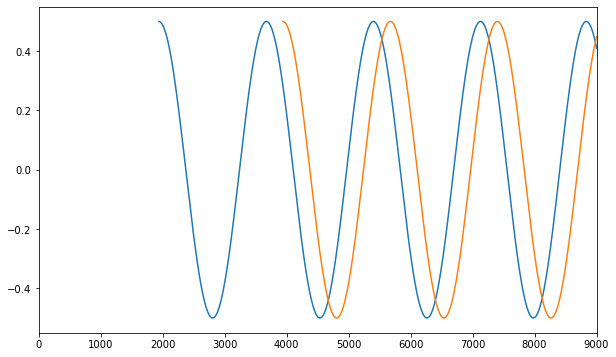

In [9]:
plt.plot(data_simul_temp["sync_0"][0])
plt.plot(data_simul_temp["sync_0"][1])
plt.xlim(0,9000)

In [10]:
# Trimming & dDownsampling to 50 Hz
sampling_rate_new = 50
data_trim = {}
data_down = {}

for con in conditions:
    # Trim data_mix to get rid of nans
    data_trim[con] = [
        # remove first and last 6 s (extra long because of lag)
        data_simul_temp[con][i][6*sampling_rate:-6*sampling_rate]
        for i in participants
    ]
    data_down[con] = [
        data_trim[con][i][::40]
        for i in participants
    ]
    
data = deepcopy(data_down)
for con in conditions:
    np.save(f"data/simulation/data_{con}.npy", data[con])


[ True  True  True ...  True  True  True]


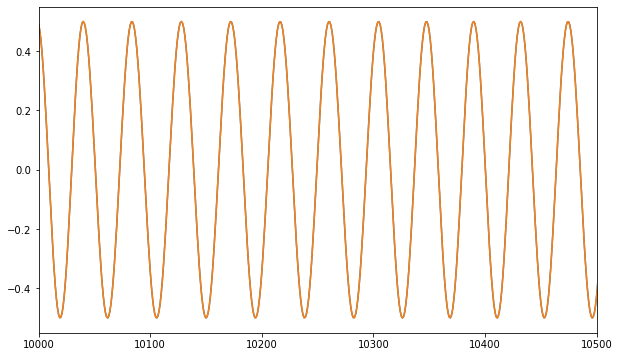

In [12]:
# Sanity check
# Should be all equal and true if noise_spread = 0
lag_new = 1*sampling_rate_new
a = data
plt.xlim(10000,10500)
plt.plot(a["sync_0"][0])
plt.plot(a["sync_0"][1][lag_new:])

print(np.equal(a["sync_0"][0][:-lag_new],a["sync_0"][1][lag_new:]))

### Deep Learning